In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 500)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'items.csv', 'shops.csv']


In [2]:
sample = pd.read_csv("../input/sample_submission.csv")
items = pd.read_csv("../input/items.csv")
item_categories = pd.read_csv("../input/item_categories.csv")
shops = pd.read_csv("../input/shops.csv")
sales_train = pd.read_csv("../input/sales_train.csv")
test = pd.read_csv("../input/test.csv")

Before we get any further, lets review what's important so far. The task is to predict a month of sales counts for a set of stores and the items that each store sells. We're given dataframes items, item_categories, and shops, all of which have columns mostly consisting of numerical ID references. More importantly, We're given a log of transactions every day over the course of 33 consecutive months leading up to the test month, where each row in this dataframe corresponds to a particular item being sold (or returned) at a particular store for a price at a specified date and time. In order to turn this into a more natural regression format, we'll want to construct a new training matrix or edit a current existing one whereby we have a target feature representing total item count sold for an item during a specific month and store. 

Now we'll quickly check how complete our data is before we hop into visualization.

From here, we can make a baseline prediction. An intuitive guess would be (assuming we've constructed said traininng matrix described above) to take the average across all months for each store's item's, and have that mean be the prediction for our test month if that combination of item and store does in fact exist in the test set. 

In [3]:
#group by date block, then shop, then items sold at that shop during that month
sorted_sales = sales_train.groupby(["date_block_num", "shop_id", "item_id"])["item_cnt_day"].sum()

#mean value of every item sold per month
mean_monthly_sales = sorted_sales.groupby(["shop_id", "item_id"]).mean()
m = mean_monthly_sales.to_frame().reset_index()
m = m.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
def r(x):
    return int(round(x))
m["item_cnt_month"] = m["item_cnt_month"].apply(r)
merged = test.merge(m, on=["shop_id", "item_id"], how="left")
merged = merged.fillna(0)
submission = merged[["ID", "item_cnt_month"]]
submission.to_csv("initial_mean_prediction.csv", index = False)

Ok, that got us a score of 2.95236, which is not that great. An observation from what we've learned so far is that the scoreboard metric isn't exactly clear. It's better to have a lower score, with the top solutions nearing a score of 0. This will be important later on when we choose our loss function to optimize, since the idea is to have similar objective functions between the leaderboard metric and our loss function. Before we start some EDA, let's create one more baseline model recommended from the kaggle forums.

Found on discussion threads,

"A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference."

In [4]:
last_month_daily_sales = sales_train.loc[sales_train["date_block_num"] == 33]
grouped_oct_sales = last_month_daily_sales.groupby(["shop_id", "item_id"])["item_cnt_day"].sum()
oct_sales = grouped_oct_sales.to_frame().reset_index()
prediction = test.merge(oct_sales, on = ["shop_id", "item_id"], how = "left")
prediction = prediction.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
prediction = prediction.fillna(0)
prediction["item_cnt_month"] = prediction["item_cnt_month"].clip(0,20)
prediction = prediction[["ID", "item_cnt_month"]]
print(prediction.shape)
prediction.to_csv("prev_val_benchmark.csv", index=False)

(214200, 2)


Now we can begin constructing a training matrix that is much more useful to us than the initial given one. Going off our previous idea, we'll want to of course have a column representing the target variable for each month. Additionally, since in any given month it isn't guarenteed that every shop/item combination will be accounted for, meaning if no one buys an item/shop combination that exists, it just doesnt show up, so we want to ensure it does with a count of 0 for that month. It turns out that generating every possible combination in the loop below creates over 65 million rows, which is a pretty big training matrix. In order to minimize computation time we'll limit the this training matrix to instead only include shop/item combinations present in the test set, which simultaneously takes advantage of the data leakage.

In [5]:
test_shops, test_items  = test["shop_id"].unique(), test["item_id"].unique()
print(test.shape, len(test_shops) * len(test_items))
#so the test set consists of all unique combinations of these two sets
#only get the sales of shops that are present in test set
leaky_sales = sales_train[sales_train["shop_id"].isin(test_shops)]
#only get the sales of item/shop combinations that are in the test set
leaky_sales = leaky_sales[leaky_sales["item_id"].isin((test_items))]
blocks = list(range(0,34))
unique_shops = leaky_sales["shop_id"].unique()
unique_items = leaky_sales["item_id"].unique()
combinations = []
for block in blocks:
    for shop in sorted(unique_shops):
        for item in sorted(unique_items):
            combinations.append([block, shop, item])
combinations = pd.DataFrame(combinations, columns = ["date_block_num", "shop_id", "item_id"])

print(combinations.shape)

(214200, 3) 214200
(6734448, 3)


Since the test set consists of all combinations between the unique shop and item ids in the test set, we don't have to worry about figuring out which combinations to drop from those created in the loops above (i.e. potentially introducing a shop/item combination that doesn't exist in the test set).

In [6]:
category_subset = items[["item_id", "item_category_id"]]
combinations = combinations.merge(category_subset, on = ["item_id"], how = "left")
new_test = test.merge(category_subset, on = ["item_id"], how = "left")
combinations = combinations.merge(leaky_sales, on = ["date_block_num", "shop_id", "item_id"], how='left')
combinations = combinations[["date_block_num", "shop_id", "item_id", "item_category_id"]]
print(combinations.head())
print(combinations.shape)
#Create target variable leaked_combos["item_cnt_month"]
leaky_sales["item_cnt_day"] = leaky_sales["item_cnt_day"].clip(0,20)
target = leaky_sales.groupby(["date_block_num", "shop_id", "item_id"], as_index = False)["item_cnt_day"].sum()
train = combinations.merge(target, on = ["date_block_num", "shop_id", "item_id"], how = "left").fillna(0)
train["item_cnt_day"] = train["item_cnt_day"].clip(0,20)
train.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"}, inplace = True)
new_test["date_block_num"] = 34
new_test.drop("ID", axis = 1, inplace = True)
print(new_test.head())
print(train.head())
print(train.shape)
print(train.isna().sum())


   date_block_num  shop_id  item_id  item_category_id
0               0        2       30                40
1               0        2       31                37
2               0        2       32                40
3               0        2       33                37
4               0        2       38                41
(7358728, 4)
   shop_id  item_id  item_category_id  date_block_num
0        5     5037                19              34
1        5     5320                55              34
2        5     5233                19              34
3        5     5232                23              34
4        5     5268                20              34
   date_block_num  shop_id  item_id  item_category_id  item_cnt_month
0               0        2       30                40             0.0
1               0        2       31                37             0.0
2               0        2       32                40             0.0
3               0        2       33                37      

**Data Visualization** 

Now that we've created some baseline models, we can explore some data visualization in order to maybe see some underlying trends, create some features based off of what we think is important, explore for outliers, and just in general get a better grasp on what's going on in our data. We'll start off by visualizing total sales for each month by how many items are sold (indepedent of store/item).

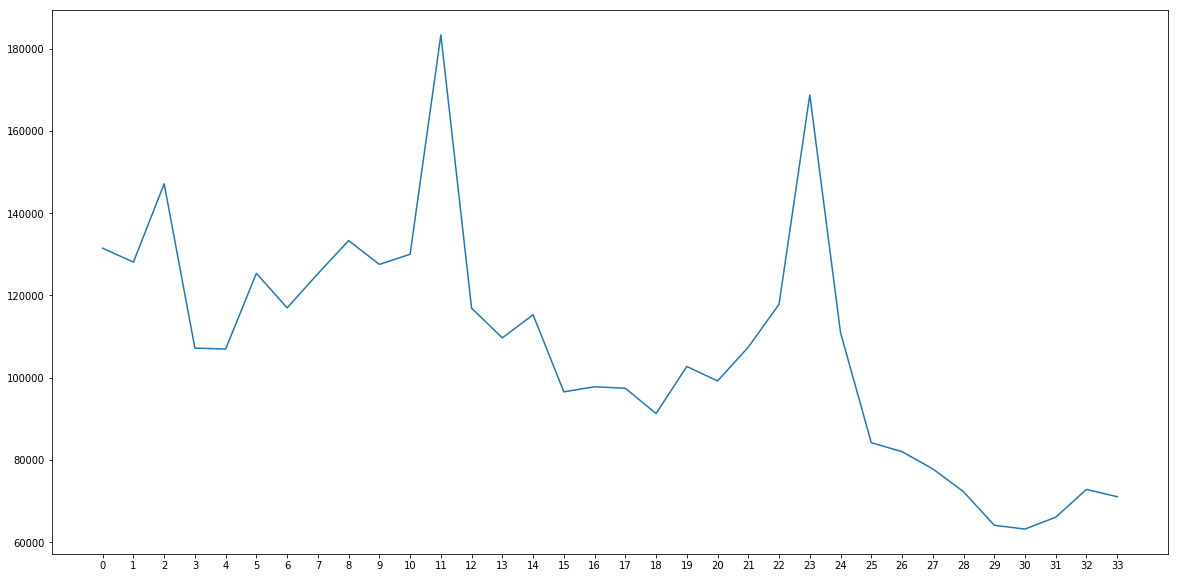

In [7]:
import matplotlib.pyplot as plt
monthly_total_item_cnt = sales_train.groupby("date_block_num", as_index = False)["item_cnt_day"].sum()
months,counts = monthly_total_item_cnt.date_block_num, monthly_total_item_cnt.item_cnt_day
plt.figure(figsize=(20,10)) 
plt.xticks(np.arange(0, 34, 1.0))
plt.plot(months,counts)

From this it looks like theres a huge spike in sales during November for both years. This is particularly significant because our test set is during November of the following year. As of now, I suspect this is because of holiday shopping.

Now since we know that about half of our test data includes in shop/item combos not introduced in our training data, it would be helpful to see what item categories, shops, and items are the most popular so that we can identify potential trends and predictors for these new combinations.

<BarContainer object of 60 artists>

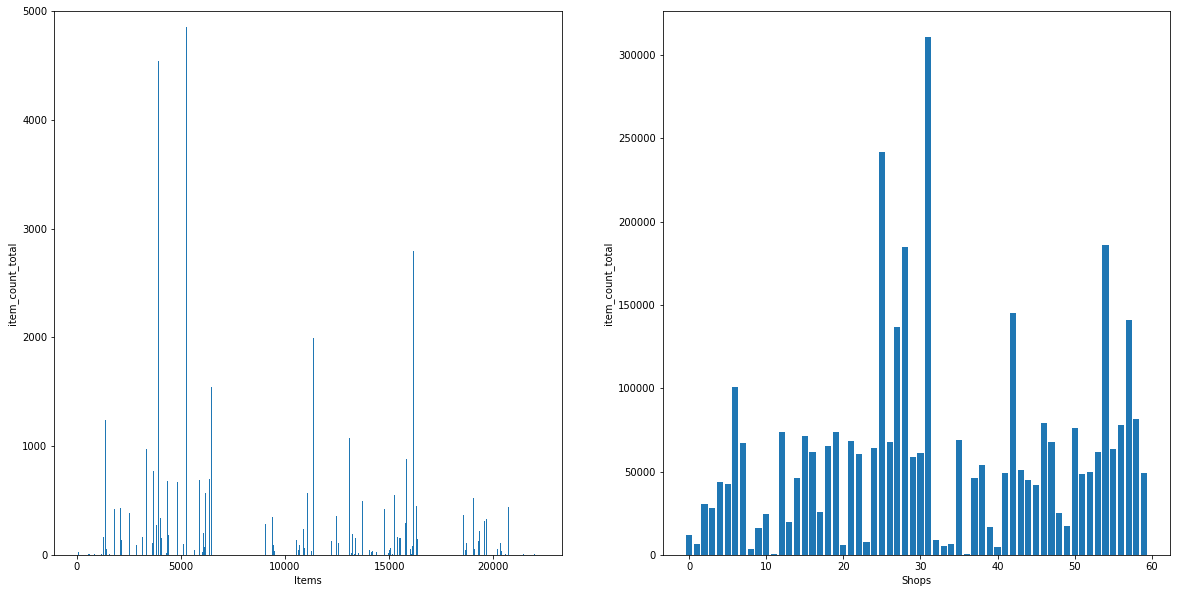

In [8]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [20,10])
plt.subplot(121)
item_category_sales_counts = leaky_sales.groupby("item_id", as_index = False)["item_cnt_day"].sum()
item_category_sales_counts = item_category_sales_counts.sort_values(by="item_cnt_day", ascending=False)
categories, counts = item_category_sales_counts.item_id, item_category_sales_counts.item_cnt_day
plt.ylim(0, 5000)

plt.xlabel("Items")
plt.ylabel("item_count_total")
plt.bar(categories,counts)

plt.subplot(122)
shop_sales_counts = sales_train.groupby("shop_id", as_index = False)["item_cnt_day"].sum()
shopz, counts = shop_sales_counts.shop_id, shop_sales_counts.item_cnt_day
plt.xlabel("Shops")
plt.ylabel("item_count_total")
plt.bar(shopz,counts)

0.5 59200.0


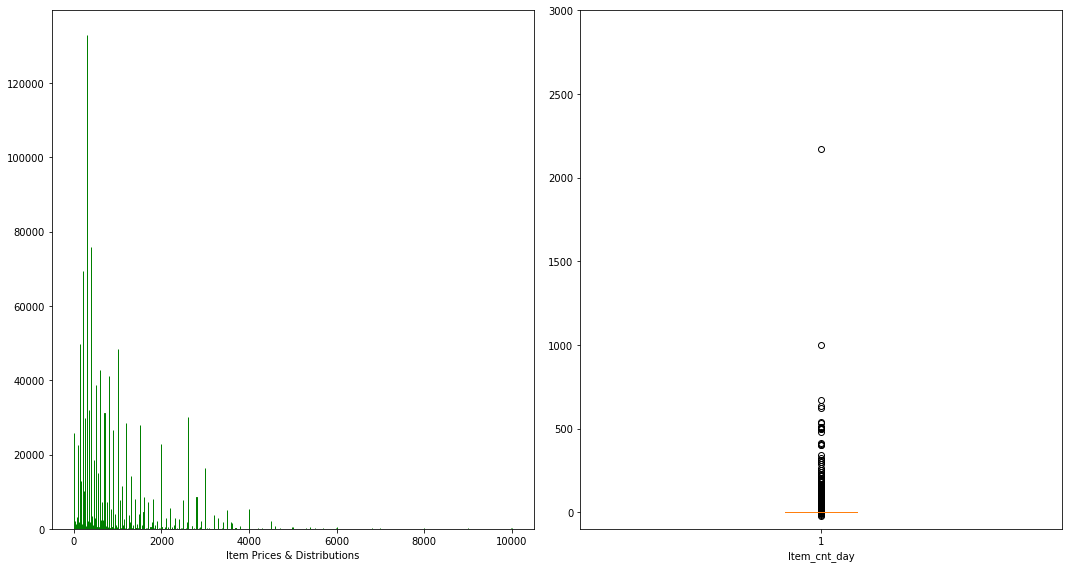

In [9]:
#item price scatter plot
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [15,8])
item_prices = leaky_sales.item_price
bins = [i for i in range(0,10000)]
plt.subplot(121)
plt.hist(item_prices, bins = bins, color = "red", edgecolor = "green")
plt.xlabel("Item Prices & Distributions")
prices = sorted(item_prices.unique())
print(prices[0], prices[-1])
plt.subplot(122)
plt.xlabel("Item_cnt_day")
plt.boxplot(sales_train.item_cnt_day)
plt.ylim(-100, 3000)
plt.tight_layout()

So it looks like the distribution of items sold across shops and categories is pretty scattered and far from uniform. 

**Feature Engineering**

5. Total shop/item sales - shop/item_total_sales 
6. Mean item price - mean_item_price
7. mean shop/item price - mean_shop/item_price
8. Total shop/item count - shop/item_total_cnt
9. Shop/item count from last {1,2,3,6,12} months - shop/item_cnt_month_lag{1,2,3,6,12}
10. Total shop sales from {1,2,3,6,12} months ago - shop_total_sales_month_lag1{1,2,3,6,12}
11. Total item sales from {1,2,3,6,12} months ago- item_total_sales_month_lag{1,2,3,6,12}
12. Mean monthly shop/item count from last three months - shop_item_mean_cnt_month_lag3 *
13. Mean monthly total shop sales from last three months - shop_mean_total_sales_month_lag3 *
14. Mean monthly total item sales from last three months - item_mean_total_sales_month_lag3 *
15. Mean item_price over last three months

In [10]:
#feature 5, 6, 7, 8, 9, 10, 11
leaky_sales = leaky_sales[leaky_sales["item_price"] >= 0]
all_data = pd.concat([train, new_test], axis= 0)

feature_5 = leaky_sales.groupby(["shop_id", "item_id"], as_index = False)["item_price"].sum()
feature_5.rename(index = str, columns = {"item_price" : "shop/item_total_sales"}, inplace = True)
all_data = all_data.merge(feature_5, on = ["shop_id", "item_id"], how = "left").fillna(0)

feature_8 = leaky_sales.groupby(["shop_id", "item_id"], as_index = False)["item_cnt_day"].sum()
feature_8.rename(index = str, columns = {"item_cnt_day" : "shop/item_total_cnt"}, inplace = True)
all_data = all_data.merge(feature_8, on = ["shop_id", "item_id"], how = "left").fillna(0)

feature_6 = leaky_sales.groupby("item_id", as_index = False)["item_price"].mean()
feature_6.rename(index = str, columns = {"item_price" : "mean_item_price"}, inplace = True)
all_data = all_data.merge(feature_6, on = "item_id", how = "left")

feature_7 = leaky_sales.groupby(["shop_id", "item_id"], as_index = False)["item_price"].mean()
feature_7.rename(index = str, columns = {"item_price" : "shop/item_mean_price"}, inplace = True)
all_data = all_data.merge(feature_7, on = ["shop_id", "item_id"], how = "left")

#fill shop/item combinations where a sale has never been made (resulting in a NAN for that particular shop/item_mean_price)
#replace these values with the mean item price across all shops
all_data["shop/item_mean_price"] = all_data.groupby("item_id")["shop/item_mean_price"].transform(lambda x: x.fillna(x.mean()))

print(all_data.isna().sum())
print(all_data.shape)
print(all_data.head())
print(all_data.describe().T)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


date_block_num               0
item_category_id             0
item_cnt_month               0
item_id                      0
shop_id                      0
shop/item_total_sales        0
shop/item_total_cnt          0
mean_item_price          16128
shop/item_mean_price     16128
dtype: int64
(7572928, 9)
   date_block_num  item_category_id  item_cnt_month  item_id  shop_id  \
0               0                40             0.0       30        2   
1               0                37             0.0       31        2   
2               0                40             0.0       32        2   
3               0                37             1.0       33        2   
4               0                41             0.0       38        2   

   shop/item_total_sales  shop/item_total_cnt  mean_item_price  \
0                1096.00                  4.0       324.562531   
1                5008.42                  8.0       573.793088   
2                1609.00                 11.0       250.08

In [11]:
lag_months = [1,2,3,6,12]
for lag in lag_months:
    feature_9 = leaky_sales.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"].sum()
    feature_9.date_block_num = feature_9.date_block_num + lag
    feature_9.rename(index = str, columns = {"item_cnt_day" : "shop/item_cnt_month_lag{}".format(lag)}, inplace = True)
    all_data = all_data.merge(feature_9, on = ["date_block_num", "shop_id", "item_id"], how = "left")
    all_data["shop/item_cnt_month_lag{}".format(lag)].fillna(0, inplace=True)
    
    feature_10 = leaky_sales.groupby(["date_block_num", "shop_id"], as_index = False)["item_price"].sum()
    feature_10.date_block_num = feature_10.date_block_num + lag
    feature_10.rename(index = str, columns = {"item_price" : "shop_total_sales_month_lag{}".format(lag)}, inplace = True)
    all_data = all_data.merge(feature_10, on = ["date_block_num", "shop_id"], how = "left")
    all_data["shop_total_sales_month_lag{}".format(lag)].fillna(0, inplace=True)
    
    feature_11 = leaky_sales.groupby(["date_block_num", "item_id"], as_index = False)["item_price"].sum()
    feature_11.date_block_num = feature_11.date_block_num + lag
    feature_11.rename(index = str, columns = {"item_price" : "item_total_sales_month_lag{}".format(lag)}, inplace = True)
    all_data = all_data.merge(feature_11, on = ["date_block_num", "item_id"], how = "left")
    all_data["item_total_sales_month_lag{}".format(lag)].fillna(0, inplace=True)


In [12]:
for block in range(12, 35):
    lower = block - 3
    sub3_train = all_data[all_data.date_block_num >= lower]
    sub3_train = sub3_train[sub3_train.date_block_num < block]
    sub3_leaky_sales = leaky_sales[leaky_sales.date_block_num >= lower]
    sub3_leaky_sales = sub3_leaky_sales[sub3_leaky_sales.date_block_num < block]
    feature_15 = sub3_leaky_sales.groupby("item_id", as_index = False)["item_price"].mean()
    feature_15.rename(index = str, columns = {"item_price" : "mean_item_price_lag3"}, inplace = True)
    feature_15["date_block_num"] = block
    
    feature_12 = sub3_train.groupby(["shop_id", "item_id"], as_index = False)["item_cnt_month"].mean()
    feature_12.rename(index = str, columns = {"item_cnt_month" : "mean_shop/item_cnt_lag3"}, inplace = True)
    feature_12["date_block_num"] = block
    
    feature_13 = sub3_leaky_sales.groupby(["date_block_num", "shop_id"], as_index=False)["item_price"].sum()
    feature_13 = feature_13.groupby("shop_id", as_index=False)["item_price"].mean()
    feature_13.rename(index = str, columns = {"item_price" : "shop_mean_total_sales_month_lag3"}, inplace = True)
    feature_13["date_block_num"] = block
    
    feature_14 = sub3_leaky_sales.groupby(["date_block_num", "item_id"], as_index=False)["item_price"].sum()
    feature_14 = feature_14.groupby("item_id", as_index=False)["item_price"].mean()
    feature_14.rename(index = str, columns = {"item_price" : "item_mean_total_sales_month_lag3"}, inplace = True)
    feature_14["date_block_num"] = block
    if block == 12:
        m12 = feature_12.copy()
        m13 = feature_13.copy()
        m14 = feature_14.copy()
        m15 = feature_15.copy()
    else:
        m12 = pd.concat([m12, feature_12.copy()], axis = 0)
        m13 = pd.concat([m13, feature_13.copy()], axis = 0)
        m14 = pd.concat([m14, feature_14.copy()], axis = 0)
        m15 = pd.concat([m15, feature_15.copy()], axis = 0)

In [13]:
all_data = all_data.merge(m12, on = ["date_block_num", "shop_id", "item_id"], how = "left")
all_data = all_data.merge(m13, on = ["date_block_num", "shop_id"], how = "left")
all_data = all_data.merge(m14, on = ["date_block_num", "item_id"], how = "left")
all_data = all_data.merge(m15, on = ["date_block_num", "item_id"], how = "left")

all_data["mean_shop/item_cnt_lag3"].fillna(0, inplace = True)
all_data["shop_mean_total_sales_month_lag3"].fillna(0, inplace = True)
all_data["item_mean_total_sales_month_lag3"].fillna(0, inplace = True)

print(all_data.isna().sum())
print(all_data.describe().T)

date_block_num                            0
item_category_id                          0
item_cnt_month                            0
item_id                                   0
shop_id                                   0
shop/item_total_sales                     0
shop/item_total_cnt                       0
mean_item_price                       16128
shop/item_mean_price                  16128
shop/item_cnt_month_lag1                  0
shop_total_sales_month_lag1               0
item_total_sales_month_lag1               0
shop/item_cnt_month_lag2                  0
shop_total_sales_month_lag2               0
item_total_sales_month_lag2               0
shop/item_cnt_month_lag3                  0
shop_total_sales_month_lag3               0
item_total_sales_month_lag3               0
shop/item_cnt_month_lag6                  0
shop_total_sales_month_lag6               0
item_total_sales_month_lag6               0
shop/item_cnt_month_lag12                 0
shop_total_sales_month_lag12    

In [14]:
from math import sqrt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
#make sure columns are in same order for train and test
all_data = all_data[all_data.date_block_num >= 12]
X_test = all_data[all_data.date_block_num == 34]
y_test = X_test["item_cnt_month"]
X_test = X_test[X_test.drop("item_cnt_month", axis = 1).columns]
X_train = all_data[all_data.date_block_num <= 32]
y_train = X_train.item_cnt_month
X_train = X_train[X_train.drop("item_cnt_month", axis = 1).columns]
X_val = all_data[all_data.date_block_num == 33]
y_val = X_val.item_cnt_month
X_val = X_val[X_val.drop("item_cnt_month", axis = 1).columns]
X_trainv1, y_trainv1 = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4601349, 27)
(218924, 27)
(214200, 27)


So far XGBoost has been bittersweet, as it's giving me the best results out of all of the below models individually and combined. Unfortunately it takes too long to run to combine with the other models into a meta model; the kernel crashes every time I attempt to include it in.

In [15]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, eta = 0.2, num_round = 1000, seed = 1)
xgb_model.fit(X_trainv1, y_trainv1, eval_metric = "rmse")
# y_xgb_val = xgb_model.predict(X_val)
# y_xgb_val = y_xgb_val.clip(0,20)
# print('val set rmse: ', mean_squared_error(y_val, y_xgb_val))
y_xgb_test = xgb_model.predict(X_test)
y_xgb_test = y_xgb_test.clip(0,20)
cols = {"ID": test["ID"].values, "item_cnt_month": y_xgb_test}
print(xgb_model.feature_importances_)
submission = pd.DataFrame.from_dict(cols)
submission.to_csv("xgb_submission.csv", index=False)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:52] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0.02325924 0.01223638 0.01547126 0.00282003 0.00685297 0.13859668
 0.01726354 0.00926497 0.5071802  0.00472736 0.01187297 0.00780313
 0.00540452 0.05009821 0.00488507 0.00680014 0.01546731 0.00695798
 0.00620723 0.05160077 0.00570541 0.00823336 0.0237198  0.02758203
 0.00579485 0.01091976 0.01327487]


**Stacking**

Gradient-Boosted Methods: Catboost, lightGBM

Neural-Nets: 1 layer and 2 layer non-linear nn's.

Random Forest

Ridge Regression

In order to create meta features for our meta model, we're going to need to do a quasi cross validation loop where we can successively iterate through training data with date_block_num whom we want to include in the new train matrix, where we'll use all old training data leading up to our current_date_block num in order to predict the meta-features for the subset of data corresponding to the current date_block_num.

In order to ensure that the susbset of training data we use to train everytime is large, we'll start creating meta-features at date_block_num 22. This also ensures that we have a years worth of training data in our final meta data matrix.

Remember the end goal is to have a training matrix whose columns are date_block_num, item_id, shop_id and the predictions each model has. Then, we'll create a meta model with linear regression to predict the item_cnt_months for our test data, that of date_block_num 34, where we use this meta-data model.

In [16]:
# from tqdm import tqdm
# from catboost import CatBoostRegressor
# import lightgbm as lgb
# from keras.models import Sequential
# from keras.layers import Dense
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# #fill nan values since some of these models cant handle them
# meta_months = range(32,35)
# all_data = all_data.fillna(0)
# all_preds = np.array([])
# for block in tqdm(meta_months):
#     X_train = all_data[all_data.date_block_num < block].copy()
#     X_test = all_data[all_data.date_block_num == block].copy()
#     y_train = X_train.item_cnt_month.values
#     y_test = X_test.item_cnt_month.values
#     X_train = X_train.drop("item_cnt_month", axis = 1)
#     X_test = X_test.drop("item_cnt_month", axis = 1)
    
#     cat_features = ["date_block_num", "shop_id", "item_id", "item_category_id"]
#     cat_model = CatBoostRegressor(max_depth = 8, learning_rate = 0.3, iterations = 100, random_seed = 1)
#     cat_model.fit(X_train, y_train, cat_features)
#     y_cat_test = cat_model.predict(X_test)
# #taking too long to run
# #     xgb_model = xgb.XGBRegressor(num_round = 50, seed = 1)
# #     xgb_model.fit(X_train, y_train, eval_metric = "rmse")
# #     y_xgb_test = xgb_model.predict(X_test)
# #     if block != 34:
# #         print("xgboost rmse:" + str(mean_squared_error(y_xgb_test, y_test)**(1/2)))
    
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     params = { 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'num_leaves': 50,'learning_rate': 0.1,
#      'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}
#     gbm_model = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=50,
#                 valid_sets=lgb_val,
#                 early_stopping_rounds=5)
#     y_gbm_test = gbm_model.predict(X_test)
    
#     nn_model = Sequential()
#     nn_model.add(Dense(units=X_train.shape[1] + 1, activation="softsign", input_dim=X_train.shape[1]))
#     nn_model.add(Dense(units=40, activation = "tanh"))
#     nn_model.add(Dense(units=1, activation = "linear"))
#     nn_model.compile(loss='mse',optimizer='Adam')
#     nn_model.fit(X_train, y_train, epochs = 5, batch_size = 50000)
#     y_nn_test = nn_model.predict(X_test)

    
#     ridge_model = Ridge(alpha=1.0)
#     ridge_model.fit(X_train, y_train)
#     y_ridge_test = ridge_model.predict(X_test)
#     if block != 34:
#         print("ridge regression rmse:" + str(mean_squared_error(y_ridge_test, y_test)**(1/2)))
    
#     randomforest_model = RandomForestRegressor(max_depth=2, random_state=1, n_estimators=10)
#     randomforest_model.fit(X_train,y_train)
#     y_rf_test = randomforest_model.predict(X_test)
#     if block != 34:
#         print("randomforest rmse:" + str(mean_squared_error(y_rf_test, y_test)**(1/2)))
#     #predictions = np.array([y_cat_test, y_xgb_test, y_gbm_test, y_nn_test[:, 0], y_nn2_test[:, 0], y_ridge_test, y_rf_test])
#     predictions = np.array([y_cat_test, y_gbm_test, y_nn_test[:, 0], y_ridge_test, y_rf_test])
#     predictions = predictions.T
#     print(predictions.shape)
#     if len(all_preds) == 0:
#         all_preds = predictions
#     else:
#         print(all_preds.shape, predictions.shape)
#         all_preds = np.vstack((all_preds, predictions))
#     print(all_preds.shape)

In [17]:
# baseline_features = ["date_block_num", "shop_id", "item_id", "item_cnt_month"]
# meta_data = all_data[all_data.date_block_num >= 32][baseline_features]
# print(meta_data.shape, all_preds.shape)
# meta_data = pd.concat([meta_data.reset_index(drop=True), all_preds.reset_index(drop=True)], axis = 1)
# meta_X_train = meta_data[meta_data.date_block_num <= 33]
# meta_y_train = meta_data.item_cnt_month.values
# meta_X_train.drop("item_cnt_month", axis = 1, inplace = True)
# meta_X_test = meta_data[meta_data.date_block_num == 34]
# meta_X_test.drop("item_cnt_month", axis = 1, inplace = True)

# from sklearn.linear_model import LinearRegression

# print(meta_X_test.shape, test.shape) #need to make sure that these both have same number of rows
# print(meta_X_test.head(), test.head()) #make sure that these are also the same elements row-wise
# meta_model = LinearRegression()
# meta_model.fit(meta_X_train, meta_y_train)
# meta_predictions = meta_model.predict(meta_X_test)
# test_subset = test[["ID", "shop_id", "item_id"]].copy()
# cols = {"ID": test_susbset["ID"].values, "item_cnt_month": meta_predictions}
# meta_submission = pd.DataFrame.from_dict(cols)
# submission.to_csv("meta_model_submission.csv", index=False)

**Parameter Testing**

In [18]:
# from catboost import CatBoostRegressor

# cat_features = ["date_block_num", "shop_id", "item_id", "item_category_id"]
# cat_model = CatBoostRegressor(max_depth = 12, learning_rate = 0.3, iterations = 100, random_seed = 1)
# cat_model.fit(X_trainv1, y_trainv1, cat_features)
# # y_cat_val = cat_model.predict(X_val)
# # y_cat_val = y_cat_val.clip(0,20)
# # print('val set rmse: ', mean_squared_error(y_val, y_cat_val))
# y_cat_test = cat_model.predict(X_test)
# y_cat_test = y_cat_test.clip(0,20)
# test_subset = test[["ID", "shop_id", "item_id"]].copy()
# cols = {"ID": test_subset["ID"].values, "item_cnt_month": y_cat_test}
# cat_submission = pd.DataFrame.from_dict(cols)
submission.to_csv("cat_submission.csv", index=False)

Score of 1.14 which is best yet, moved me up around 100 positions on the leaderboard.

In [19]:
# import lightgbm as lgb
# lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = ["date_block_num", "shop_id", "item_id", "item_category_id"])
# lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# gbm_model = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_val,
#                 early_stopping_rounds=5)
# y_gbm_val = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)
# y_gbm_test = y_gbm_test.clip(0,20)
# cols = {"ID": test_subset["ID"].values, "item_cnt_month": y_gbm_test}
# print(xgb_model.feature_importances_)
# submission = pd.DataFrame.from_dict(cols)
# submission.to_csv("lgb_submission.csv", index=False)

In [20]:
# from keras.models import Sequential
# from keras.layers import Dense

# nn_model = Sequential()
# nn_model.add(Dense(units=X_train.shape[1] + 1, activation="softsign", input_dim=X_train.shape[1]))
# nn_model.add(Dense(units=40, activation = "tanh"))
# nn_model.add(Dense(units=40, activation="softplus", input_dim=X_train.shape[1]))
# nn_model.add(Dense(units=1, activation = "linear"))
# nn_model.compile(loss='mse',optimizer='Adam')
# nn_model.fit(X_train, y_train, epochs = 5, batch_size = 100000)
# y_nn_val = nn_model.predict(X_val)
# print('val set rmse: ', mean_squared_error(y_val, y_nn_val))

In [21]:
# nn2_model = Sequential()
# nn2_model.add(Dense(units= X_train.shape[1] + 1, activation="tanh", input_dim=X_train.shape[1]))
# nn2_model.add(Dense(units=X_train.shape[1] + 1, activation = "relu"))
# nn2_model.add(Dense(units=1, activation = "linear"))
# nn2_model.compile(loss='mse',optimizer='Adam')
# nn2_model.fit(X_train, y_train, epochs = 5, batch_size = 100000)
# y_nn2_val = nn2_model.predict(X_val)
# print('val set rmse: ', mean_squared_error(y_val, y_nn2_val))

In [22]:
# from sklearn.linear_model import Ridge

# ridge_model = Ridge(alpha=1)
# ridge_model.fit(X_train, y_train)
# y_ridge_val = ridge_model.predict(X_val)
# y_ridge_val = y_ridge_val.clip(0,20)
# print('val set rmse: ', mean_squared_error(y_val, y_ridge_val))

In [23]:
# from sklearn.ensemble import RandomForestRegressor

# randomforest_model = RandomForestRegressor(max_depth=2, random_state=1, n_estimators=20)
# randomforest_model.fit(X_train,y_train)
# y_rf_val = randomforest_model.predict(X_val)
# y_rf_val = y_rf_val.clip(0,20)
# print('val set rmse: ', mean_squared_error(y_val, y_rf_val))
randomforest_model.feature_importances_

NameError: name 'randomforest_model' is not defined